In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
pwd = "/content/drive/MyDrive/ECE661FinalProj_OODD"
os.chdir(pwd)

Mounted at /content/drive


In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
def swish(x):
    return x/(1+torch.exp(-x))

In [4]:
# define the Resnet20 mode;
class Resnet20(nn.Module):
    def __init__(self):
        super(Resnet20, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.batchnorm0 = nn.BatchNorm2d(16)
        
        self.conv1a = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1a = nn.BatchNorm2d(16)
        self.conv1b = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1b = nn.BatchNorm2d(16)
        self.conv1c = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1c = nn.BatchNorm2d(16)
        self.conv1d = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1d = nn.BatchNorm2d(16)
        self.conv1e = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1e = nn.BatchNorm2d(16)
        self.conv1f = nn.Conv2d(16, 16, 3, padding=1)
        self.batchnorm1f = nn.BatchNorm2d(16)
        
        self.conv1_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.batchnorm1_2 = nn.BatchNorm2d(32)
        self.bypass1_2 = nn.Conv2d(16, 32, 1, stride=2)
        self.conv2a = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2a = nn.BatchNorm2d(32)
        self.conv2b = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2b = nn.BatchNorm2d(32)
        self.conv2c = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2c = nn.BatchNorm2d(32)
        self.conv2d = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2d = nn.BatchNorm2d(32)
        self.conv2e = nn.Conv2d(32, 32, 3, padding=1)
        self.batchnorm2e = nn.BatchNorm2d(32)
        
        self.conv2_3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.batchnorm2_3 = nn.BatchNorm2d(64)
        self.bypass2_3 = nn.Conv2d(32, 64, 1, stride=2)
        self.conv3a = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3a = nn.BatchNorm2d(64)
        self.conv3b = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3b = nn.BatchNorm2d(64)
        self.conv3c = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3c = nn.BatchNorm2d(64)
        self.conv3d = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3d = nn.BatchNorm2d(64)
        self.conv3e = nn.Conv2d(64, 64, 3, padding=1)
        self.batchnorm3e = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        # Inital convolution
        out = self.batchnorm0(self.conv0(x))
        out = bypass = swish(out)
        # Block 1   (condense block layers into functions)
            # Layer 1
        out = self.batchnorm1a(self.conv1a(out))
        out = swish(out)
        out = self.batchnorm1b(self.conv1b(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm1c(self.conv1c(out))
        out = swish(out)
        out = self.batchnorm1d(self.conv1d(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm1e(self.conv1e(out))
        out = swish(out)
        out = self.batchnorm1f(self.conv1f(out))
        out = bypass = swish(out + bypass)
        # Block 2
            # Layer 1
        bypass = self.bypass1_2(bypass)
        out = self.batchnorm1_2(self.conv1_2(out))
        out = swish(out)
        out = self.batchnorm2a(self.conv2a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm2b(self.conv2b(out))
        out = swish(out)
        out = self.batchnorm2c(self.conv2c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm2d(self.conv2d(out))
        out = swish(out)
        out = self.batchnorm2e(self.conv2e(out))
        out = bypass = swish(out + bypass)
        # Block 3
            # Layer 1
        bypass = self.bypass2_3(bypass)
        out = self.batchnorm2_3(self.conv2_3(out))
        out = swish(out)
        out = self.batchnorm3a(self.conv3a(out))
        out = bypass = swish(out + bypass)
            # Layer 2
        out = self.batchnorm3b(self.conv3b(out))
        out = swish(out)
        out = self.batchnorm3c(self.conv3c(out))
        out = bypass = swish(out + bypass)
            # Layer 3
        out = self.batchnorm3d(self.conv3d(out))
        out = swish(out)
        out = self.batchnorm3e(self.conv3e(out))
        out = bypass = swish(out + bypass)
        
        # Global Average Pool to go from 8x8 -> 1x1 feature maps
        out = F.avg_pool2d(out, 8)
        
        # Fully Connected Layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [5]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 as torchCIFAR10

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)


transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


In [18]:
from torchvision.datasets import SVHN
import numpy as np
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.datasets import CIFAR100

DATA_ROOT = "./data"
inTRAIN_BATCH_SIZE = 128
outBATCH_SIZE = 256
VAL_BATCH_SIZE = 100


all_testing = torchCIFAR10(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)


cifar5_test_labels = np.array(all_testing.targets)
train_indices = []
all_test_indices = []
for i in [0,1,2,3,4]:
    all_test_indices += np.where(cifar5_test_labels == i)[0].tolist()

cifar5_test_set = Subset(all_testing, all_test_indices)

other5_test_indices = []
for i in [5,6,7,8,9]:
    other5_test_indices += np.where(cifar5_test_labels == i)[0].tolist()
other5_test_set = Subset(all_testing, other5_test_indices)

other5_test_loader = DataLoader(
    other5_test_set
)

torch_test_loader = DataLoader(
    all_testing,
    batch_size = 100
)

cifar5_test_loader = DataLoader(
    cifar5_test_set,
    batch_size = VAL_BATCH_SIZE
)

cifar100_set = CIFAR100(
    root=DATA_ROOT,
    train=False,
    transform=transform_test,
    download=True
)

cifar100_loader = DataLoader(
    cifar100_set,
    shuffle=True,
    batch_size = outBATCH_SIZE
)
cifar100_test_loader = DataLoader(
    cifar100_set,
)


SVHN_Data = SVHN(
    root='./data/',
    split= 'test',
    transform=transform_test,
    download=True
)
SVHN_loader = DataLoader(
    SVHN_Data
)


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [7]:
from torchvision.datasets import MNIST

###################################################################################
#   MNIST
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda inputs1: inputs1.repeat(3, 1, 1) ),
    transforms.RandomCrop(32, padding=2),
    transforms.Normalize((0.4914), (0.2023)),
   
])
MNIST_OOD_Data = MNIST(
    root=DATA_ROOT,
    train=False,
    transform=transform_MNIST,
    download = True

)
MNIST_OOD_loader = DataLoader(
    MNIST_OOD_Data
)


####################################
from sklearn import preprocessing

def find_unif_ood_score(net, device):
  dataset_size = 1000
  UNIF_OOD_softmaxes = []
  for i in range(dataset_size):
      x = np.random.uniform(0, 255, 3072).astype(np.float32)
      norm = np.linalg.norm(x)
      x = x/norm
      unif = torch.tensor(np.reshape(x, (1,3, 32, 32)))
      output = net.forward(unif.to(device))
      softmax = F.softmax(output, dim=1)
      UNIF_OOD_softmaxes.append(softmax[0][torch.argmax(softmax)].item())
  return UNIF_OOD_softmaxes

def find_gaussian_ood_score(net, device):
  GAUSSIAN_OOD_softmaxes = []
  for i in range(1000):
      x = np.random.normal(0, 255, 3072).astype(np.float32)
      normalized = np.linalg.norm(x)
      x = x/normalized
      norm = torch.tensor(np.reshape(x, (1,3, 32, 32)))
      output = net.forward(norm.to(device))
      softmax = F.softmax(output, dim=1)
      GAUSSIAN_OOD_softmaxes.append(softmax[0][torch.argmax(softmax)].item())
  return GAUSSIAN_OOD_softmaxes

In [8]:
def plot_roc(ID_vals, OOD_vals, label ):
  TPRs = []     #  true positive rates
  FPRs = []     # false positive rates
  AUROC = []    # will contain the AUROC approximation segments
  opt = .95
  opt2=.05
  opt1_TPR = 0
  opt1_FPR = 0
  distTPR = 1000
  opt2_TPR = 0
  opt2_FPR = 0
  distFPR = 1000
  prev_FPR = 0
  for i in tqdm(np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000)):
      TPR = sum(OOD_vals < i)/len(OOD_vals)
      FPR = sum(ID_vals < i)/len(ID_vals)
      TPRs.append(TPR)
      FPRs.append(FPR)
      AUROC.append((FPR-prev_FPR)*TPR)
      prev_FPR = FPR 
      if(np.abs(opt-TPR)<distTPR):
        opt1_TPR, opt1_FPR, distTPR= TPR, FPR, (np.abs(opt-TPR))
      if(np.abs(opt2-FPR)<distFPR):
        opt2_TPR, opt2_FPR, distFPR= TPR, FPR, (np.abs(opt2-FPR))
  plt.plot(FPRs, TPRs, label = label)
  print(label)
  print(f"FPR at 95%TPR = {opt1_FPR}")
  print(f"TNR at 95%TPR = {1-opt1_FPR}")
  print(f"AUROC: {sum(AUROC)}")

In [9]:
def plot_dataset_rocs(ID_datasets, OOD_datasets, title, labels):
  space = np.linspace(0,1,1000)
  tpr95 = [.95]*1000
  plt.plot(space, tpr95, "k--", linewidth=.5, label = "TPR = 95%")
  plt.plot([0,1], [0,1], "k--", linewidth=.5)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  for i in range(len(OOD_datasets)):
    plot_roc(ID_datasets[i], OOD_datasets[i], labels[i])
  plt.legend()
  plt.show()

In [10]:
def energy_fun(cnn_output, T):
  return -T* torch.logsumexp(cnn_output / T, dim=1)

In [11]:
def find_ind_scores(test_loader, model, energy=False):
  total_examples = 0
  correct_examples = 0
  val_loss = 0 

  energy_corr_score = []
  energy_fals_score = []

  softmax_corr_score = []
  softmax_fals_score = []

  T = 1
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(cifar5_test_loader):
        if batch_idx > 0.50*len(cifar5_test_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.type(torch.LongTensor)
            targets = targets.to(device)
            # compute the output and loss
            output = model.forward(inputs)
            softmax = F.softmax(output, dim=1)
            energy_out = energy_fun(output, T)

            # count the number of correctly predicted samples in the current batch
            total_examples += targets.size()[0]
            batch_preds = torch.argmax(output, dim=1)
            correct_mask = (batch_preds == targets)
            correct_examples += correct_mask.int().sum().item()
            soft_batch_preds = torch.argmax(softmax, dim=1)
            for i in range(len(correct_mask)):
                if correct_mask[i]:
                    energy_corr_score.append(energy_out[i].item())
                    softmax_corr_score.append(softmax[i][soft_batch_preds[i]].item())
                else:
                    energy_fals_score.append(energy_out[i].item())
                    softmax_fals_score.append(softmax[i][soft_batch_preds[i]].item())

      print(correct_examples/total_examples)
  if energy:
    return energy_fals_score + energy_corr_score
  else:
    return softmax_corr_score  + softmax_fals_score
  

In [16]:
def find_ood_scores(OOD_loader, model, energy=False):
  energy_OOD_score = []
  softmax_OOD_score = []
  with torch.no_grad():
      for i, (img, target) in tqdm(enumerate(OOD_loader)):
          img = img.to(device)
          target = target.type(torch.LongTensor)
          target = target.to(device)

          output = model.forward(img)
          energy = energy_fun(output, 1)
          softmax = F.softmax(output, dim=1)
          # print(softmax.shape)
          # print(energy.shape)
          energy_OOD_score.append(energy.item())
          softmax_OOD_score.append(softmax[0][torch.argmax(softmax)].item())
  if energy:
    return energy_OOD_score
  else:
    return softmax_OOD_score

In [13]:
CHECKPOINT_FOLDER = "./saved_model"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PTH_100 = 'cifer5_cifar100_OE_resnet.pth'
cnn_100 = Resnet20().to(device)
cnn_100.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_100))["state_dict"])
cnn_100.eval()

PTH_50 = 'cifer5_cifar50_OE_resnet.pth'
cnn_50 = Resnet20().to(device)
cnn_50.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_50))["state_dict"])
cnn_50.eval()

PTH_20 = 'cifar5_cifar20_OE_resnet.pth'
cnn_20 = Resnet20().to(device)
cnn_20.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_20))["state_dict"])
cnn_20.eval()

PTH_5 = 'cifar5_cifar5_OE_resnet.pth'
cnn_5 = Resnet20().to(device)
cnn_5.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_5))["state_dict"])
cnn_5.eval()

PTH_1 = 'cifar5_cifar1_OE_resnet.pth'
cnn_1 = Resnet20().to(device)
cnn_1.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_1))["state_dict"])
cnn_1.eval()

RuntimeError: ignored

In [15]:
PTH_eng = 'ENERGY_OE_resnet20.pth'
cnn_eng = Resnet20().to(device)
cnn_eng.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, PTH_eng))["state_dict"])
cnn_eng.eval()

Resnet20(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1a): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1a): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1c): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1c): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1d): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1e): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm1e): BatchNorm2d(16, eps=1e-

In [ ]:
indscore100 = find_ind_scores(cifar5_test_loader, cnn_100)
indscore50 = find_ind_scores(cifar5_test_loader, cnn_50)
indscore20 = find_ind_scores(cifar5_test_loader, cnn_20)
indscore5 = find_ind_scores(cifar5_test_loader, cnn_5)
indscore1 = find_ind_scores(cifar5_test_loader, cnn_1)

0.76125
0.7508333333333334
0.7495833333333334
0.5566666666666666
0.54625


In [ ]:
oodscore100 = find_ood_scores(SVHN_loader, cnn_100)
oodscore50 = find_ood_scores(SVHN_loader, cnn_50)
# oodscore20 = find_ood_scores(SVHN_loader, cnn_20)
oodscore5 = find_ood_scores(SVHN_loader, cnn_5)
oodscore1 = find_ood_scores(SVHN_loader, cnn_1)

<ipython-input-32-dddecffaa1fb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
oodscore20 = find_ood_scores(SVHN_loader, cnn_20)

<ipython-input-32-dddecffaa1fb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

In [ ]:
indscores = [indscore100, indscore50, indscore20, indscore5, indscore1]
oodscores = [oodscore100, oodscore50, oodscore20, oodscore5, oodscore1]

labels = ['cifar100', 'cifar50', 'cifar20', 'cifar5', 'cifar1']

<ipython-input-8-6f1edd388ff7>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar100
FPR at 95%TPR = 0.5466666666666666
TNR at 95%TPR = 0.45333333333333337
AUROC: 0.8151783617947768


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar50
FPR at 95%TPR = 0.7283333333333334
TNR at 95%TPR = 0.2716666666666666
AUROC: 0.7447918458304321


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar20
FPR at 95%TPR = 0.8683333333333333
TNR at 95%TPR = 0.1316666666666667
AUROC: 0.5584544878532658


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar5
FPR at 95%TPR = 0.9045833333333333
TNR at 95%TPR = 0.0954166666666667
AUROC: 0.5449160148518227


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar1
FPR at 95%TPR = 0.8658333333333333
TNR at 95%TPR = 0.13416666666666666
AUROC: 0.5889360004277173


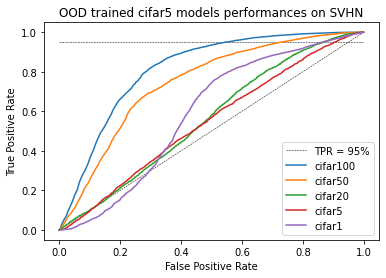

In [ ]:
plot_dataset_rocs(indscores, oodscores, "OOD trained cifar5 models performances on SVHN", labels)

In [ ]:
indscore100 = find_ind_scores(cifar5_test_loader, cnn_100)
indscore50 = find_ind_scores(cifar5_test_loader, cnn_50)
indscore20 = find_ind_scores(cifar5_test_loader, cnn_20)
indscore5 = find_ind_scores(cifar5_test_loader, cnn_5)
indscore1 = find_ind_scores(cifar5_test_loader, cnn_1)

0.76125
0.7508333333333334
0.7495833333333334
0.5566666666666666
0.54625


In [ ]:
oodscore100_cif5 = find_ood_scores(other5_test_loader, cnn_100)
oodscore50_cif5 = find_ood_scores(other5_test_loader, cnn_50)
oodscore20_cif5 = find_ood_scores(other5_test_loader, cnn_20)
oodscore5_cif5 = find_ood_scores(other5_test_loader, cnn_5)
oodscore1_cif5 = find_ood_scores(other5_test_loader, cnn_1)

<ipython-input-32-dddecffaa1fb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<ipython-input-8-6f1edd388ff7>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar100
FPR at 95%TPR = 0.72375
TNR at 95%TPR = 0.27625
AUROC: 0.7028301666666669


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar50
FPR at 95%TPR = 0.8191666666666667
TNR at 95%TPR = 0.1808333333333333
AUROC: 0.6793130833333343


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar20
FPR at 95%TPR = 0.8941666666666667
TNR at 95%TPR = 0.10583333333333333
AUROC: 0.6195044166666664


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar5
FPR at 95%TPR = 0.9983333333333333
TNR at 95%TPR = 0.0016666666666667052
AUROC: 0.4278862499999997


  0%|          | 0/1000 [00:00<?, ?it/s]

cifar1
FPR at 95%TPR = 0.9991666666666666
TNR at 95%TPR = 0.0008333333333333526
AUROC: 0.45418358333333314


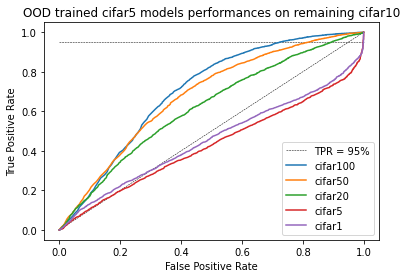

In [ ]:
indscores_cif5 = [indscore100, indscore50, indscore20, indscore5, indscore1]
oodscores_cif5 = [oodscore100_cif5, oodscore50_cif5, oodscore20_cif5, oodscore5_cif5, oodscore1_cif5]

labels = ['cifar100', 'cifar50', 'cifar20', 'cifar5', 'cifar1']
plot_dataset_rocs(indscores_cif5, oodscores_cif5, "OOD trained cifar5 models performances on remaining cifar10", labels)

<ipython-input-32-dddecffaa1fb>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

<ipython-input-8-6f1edd388ff7>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

SVHN
FPR at 95%TPR = 0.5466666666666666
TNR at 95%TPR = 0.45333333333333337
AUROC: 0.8151783617947768


  0%|          | 0/1000 [00:00<?, ?it/s]

Other5 CIFAR
FPR at 95%TPR = 0.72375
TNR at 95%TPR = 0.27625
AUROC: 0.7028301666666669


  0%|          | 0/1000 [00:00<?, ?it/s]

MNIST
FPR at 95%TPR = 0.8770833333333333
TNR at 95%TPR = 0.12291666666666667
AUROC: 0.5039572499999997


  0%|          | 0/1000 [00:00<?, ?it/s]

Uniform
FPR at 95%TPR = 0.44125
TNR at 95%TPR = 0.5587500000000001
AUROC: 0.5624925000000001


  0%|          | 0/1000 [00:00<?, ?it/s]

Gaussion
FPR at 95%TPR = 0.4583333333333333
TNR at 95%TPR = 0.5416666666666667
AUROC: 0.5481391666666667


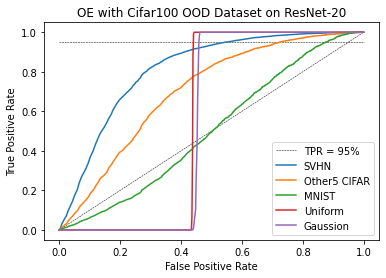

In [ ]:
## FOR CIFAR 5, 100 trained

in_score = indscore100

gaus_score = find_gaussian_ood_score(cnn_100, device)
unif_score = find_unif_ood_score(cnn_100, device)
mnist_score = find_ood_scores(MNIST_OOD_loader, cnn_100)
other5_score = oodscore100_cif5
svhn_score = oodscore100

indscores = [indscore100, indscore100, indscore100, indscore100, indscore100]
oodscores = [svhn_score, other5_score, mnist_score, unif_score, gaus_score]

labels = ['SVHN', 'Other5 CIFAR', 'MNIST', 'Uniform', 'Gaussion']
plot_dataset_rocs(indscores, oodscores, "OE with Cifar100 OOD Dataset on ResNet-20", labels)

In [20]:
indscore_eng = find_ind_scores(torch_test_loader, cnn_eng, energy=True)

gaus_score_eng = find_gaussian_ood_score(cnn_eng, device)
unif_score_eng = find_unif_ood_score(cnn_eng, device)
mnist_score_eng = find_ood_scores(MNIST_OOD_loader, cnn_eng, energy=True)
cifar100_score_eng = find_ood_scores(cifar100_test_loader, cnn_eng, energy=True)
svhn_score_eng = find_ood_scores(SVHN_loader, cnn_eng, energy=True)

0.7975


<ipython-input-16-f3998ddb1846>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, (img, target) in tqdm(enumerate(OOD_loader)):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

<ipython-input-8-6f1edd388ff7>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.linspace(min([min(ID_vals), min(OOD_vals)]), max([max(ID_vals), max(OOD_vals)]), 1000)):


  0%|          | 0/1000 [00:00<?, ?it/s]

SVHN
FPR at 95%TPR = 0.43907498463429623
TNR at 95%TPR = 0.5609250153657037
AUROC: 0.8944843205798005


  0%|          | 0/1000 [00:00<?, ?it/s]

CIFAR100
FPR at 95%TPR = 0.8468
TNR at 95%TPR = 0.1532
AUROC: 0.7805780416666678


  0%|          | 0/1000 [00:00<?, ?it/s]

MNIST
FPR at 95%TPR = 0.9119
TNR at 95%TPR = 0.08809999999999996
AUROC: 0.8301234999999999


  0%|          | 0/1000 [00:00<?, ?it/s]

Uniform
FPR at 95%TPR = 0.0
TNR at 95%TPR = 1.0
AUROC: 0.999


  0%|          | 0/1000 [00:00<?, ?it/s]

Gaussion
FPR at 95%TPR = 0.0
TNR at 95%TPR = 1.0
AUROC: 0.999


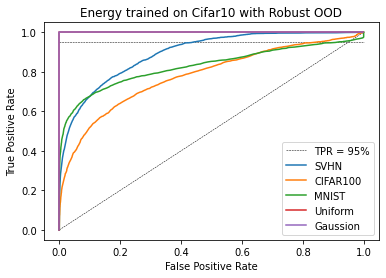

In [22]:
indscores_eng = [indscore_eng, indscore_eng, indscore_eng, indscore_eng, indscore_eng]
oodscores_eng = [svhn_score_eng, cifar100_score_eng, mnist_score_eng, unif_score_eng, gaus_score_eng]

labels = ['SVHN', 'CIFAR100', 'MNIST', 'Uniform', 'Gaussion']
plot_dataset_rocs(oodscores_eng, indscores_eng, "Energy trained on Cifar10 with Robust OOD", labels)